In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



In [4]:
# load in data from some source - could be a csv, api, ... 
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


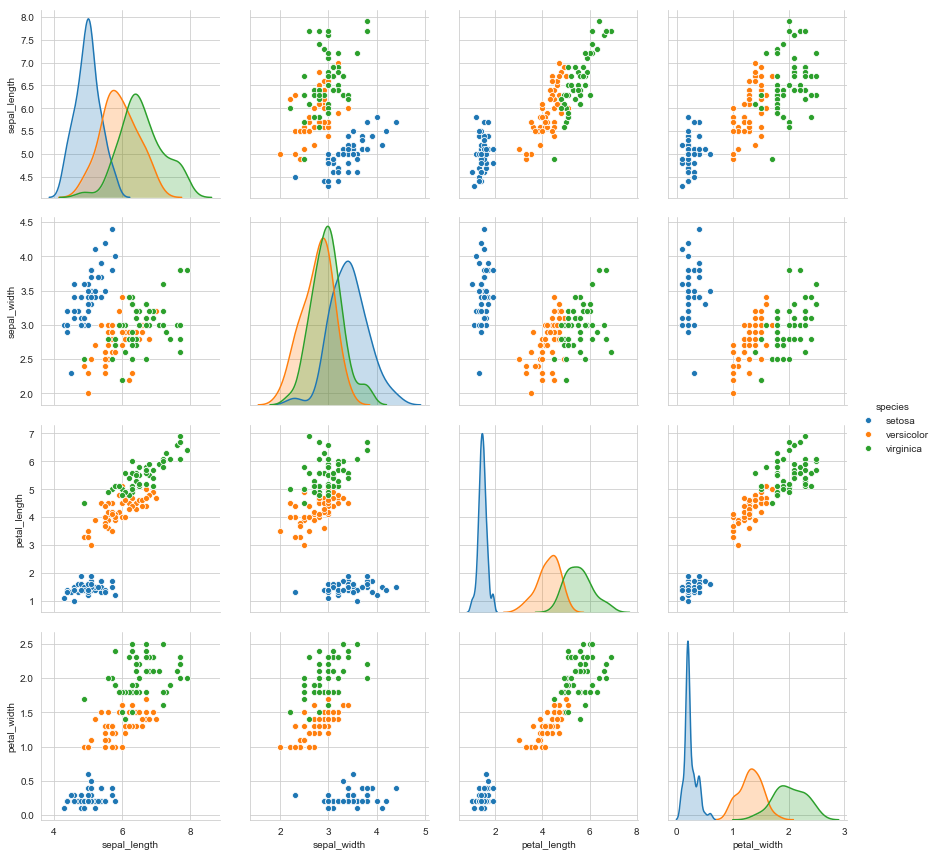

In [5]:
# exploritory analysis 
sns.set_style("whitegrid")
sns.pairplot(iris, hue='species', height=3)
plt.show()

In [6]:
# take a stratified train test split
print('Splitting train and test sets')
n_samples = 5
n = min(n_samples, iris['species'].value_counts().min())
test_df = iris.groupby('species').apply(lambda x: x.sample(n))
test_df.index = test_df.index.droplevel(0)
train_df = iris[~iris.index.isin(test_df.index)]

Splitting train and test sets


In [18]:
# now lets set up a modelling pipeline using sklearn

# a custom BaseEstimator that can switch between classifiers
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator = None):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)
    
    
# now we can create the sklearn pipeline object with all of the different classifiers we will consider and their parameter grids
steps = [('scaler', StandardScaler()), ('clf', ClfSwitcher())]
pipeline = Pipeline(steps)
parameters = [
    {
        'clf__estimator': [LogisticRegression()],
        'clf__estimator__C':[0.5, 0.75, 1]
    },
    {
        'clf__estimator': [DecisionTreeClassifier()],
        'clf__estimator__max_depth': [2,3,None],
        'clf__estimator__min_samples_leaf': [1,2]
    },
    {
        'clf__estimator': [LinearDiscriminantAnalysis()]
    }

]

pipeline

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf', ClfSwitcher(estimator=None))],
         verbose=False)

In [19]:
gscv = GridSearchCV(pipeline, parameters, cv=3, scoring="accuracy")
print('training model')
gscv.fit(train_df.iloc[:,:4], train_df['species'])

training model


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf', ClfSwitcher(estimator=None))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'clf__estimator': [LogisticRegression(C=0.5,
                                                                class_weight=None,
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_rati...
                

In [26]:
# lets check out the results 
print('best model: \n\n', gscv.best_estimator_)
print('\ntest set accuracy: ',gscv.score(test_df.iloc[:,:4], test_df['species']))

best model: 

 Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 ClfSwitcher(estimator=LogisticRegression(C=0.5,
                                                          class_weight=None,
                                                          dual=False,
                                                          fit_intercept=True,
                                                          intercept_scaling=1,
                                                          l1_ratio=None,
                                                          max_iter=100,
                                                          multi_class='auto',
                                                          n_jobs=None,
                                                          penalty='l2',
                                                          random_state=None,
                        

In [128]:
# finally we can make predictions on a brand new observation
new_value = np.array([5.1, 3.8, 1.5, 0.3]).reshape(1,-1)

prediction = gscv.predict(new_value)
print('predicted class:', prediction[0])

predicted class: setosa
